In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from doe_lhs import lhs 
def unnormalize(val, maxVal, minVal): 
    return val * (maxVal - minVal) + minVal  

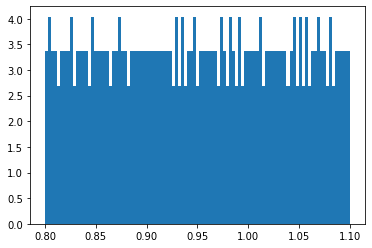

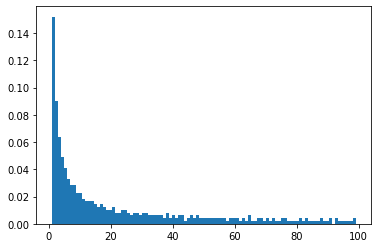

In [3]:
tmp = lhs(2, 501, criterion='m', seeded=233) 

plot_range = np.linspace(0.8, 1.1, 101)
frame_range = np.logspace(np.log10(1.), np.log10(100.), 21) 

freq_samp = unnormalize(tmp[:, 0], min(plot_range), max(plot_range)) 
frame_samp = 10 ** unnormalize(tmp[:, 1], np.log10(min(frame_range)), np.log10(max(frame_range))) 

plt.hist(freq_samp, bins=101, density=True); 
plt.figure() 
plt.hist(frame_samp, bins=101, density=True); 

In [ ]:
%load_ext autoreload
%autoreload 2 
%config InlineBackend.figure_format = 'retina' 

import numpy as np
import acousticBayesv2 as ab
import matplotlib.pyplot as plt
import pymc3 as pm
from pymc3 import SamplingError
import time
import os
import uuid
from pymc3.variational.callbacks import CheckParametersConvergence
from tqdm import tqdm
import gc 
ar = np.array

from doe_lhs import lhs 

def unnormalize(val, maxVal, minVal): 
    return val * (maxVal - minVal) + minVal  

import matplotlib
matplotlib.use('Agg')

repeats = 10;

if __name__ == "__main__":
    for repeat in range(repeats):
        # Designs
        design = {}
        design['omega'] = np.array([]) #,1.0,1.01,1.02,0.96])
        design['voltage'] = np.array([]) #,1,1,1,1])
        design['framerate'] = np.array([]) #,1,1,1,1])
        design['Ne'] = design['omega'].shape[0]
        design['Np'] = 8
        #############################################################
        ### CONSIDER DROPPING THIS FOR INCREASING INFORMATION CONTENT
        #############################################################
        design['Nt'] = 32

        # Parameters
        param = {}
        param['alpha'] = 1
        param['beta'] = 1
        param['gamma'] = 0.01
        param['sigma'] = 0.3 # 1.0
        param['sigma_a'] = 1
        param['sigma_b'] = 1
        param['s'] = 0.01

        seed = np.random.randint(1, 9999) # 2343
        # np.random.seed(seed)
        pm.set_tt_rng(seed)

        # Prior hyper parameters
        param['mu_alpha'] = 0
        param['mu_beta'] = 0
        param['mu_gamma'] = np.log(param['gamma'])
        param['mu_sigma'] = np.log(param['sigma'])

        param['sigma_alpha'] = 0.5
        param['sigma_beta'] = 0.5
        param['sigma_gamma'] = 0.5
        param['sigma_sigma'] = 0.5

        lines_ = [('alpha', {}, [param['alpha']]),
                  ('beta', {}, [param['beta']]),
                  ('gamma', {}, [param['gamma']]),
                  ('sigma', {}, [param['sigma']])]

        SMC = True; VI = False; ## inference choices 
        LHS = True; random = False ## design choices 
        try:
            assert (SMC + VI) <= 1
        except AssertionError as e:
            e.args += ('Please choose an inference engine to run on.', '')
            raise

        if VI:
            print('RUNNING IN VI MODE')
        elif SMC:
            print('RUNNING IN SMC MODE') 
        if LHS: 
            print('RUNNING IN LHS MODE')
        save = True;
        progressbar = False

        postSize = 1500

        # plot_range = np.linspace(0.9, 1.1, 201)
        plot_range = np.linspace(0.8, 1.1, 101)
        frame_range = np.logspace(np.log10(1.), np.log10(100.), 21)  
        if LHS: 
            tmp = lhs(2, 11, criterion='m', seeded=seed) 
        
            freq_samp = unnormalize(tmp[:, 0], min(plot_range), max(plot_range)) 
            frame_samp = 10 ** unnormalize(tmp[:, 1], np.log10(min(frame_range)), np.log10(max(frame_range))) 
        
        elif random: 
            tmp = np.random.rand(11,2) 
            
            freq_samp = unnormalize(tmp[:, 0], min(plot_range), max(plot_range)) 
            frame_samp = 10 ** unnormalize(tmp[:, 1], np.log10(min(frame_range)), np.log10(max(frame_range))) 
            
        expI_chosen = [];

        timings = []; obs_timings = 0; inf_timings = 0; des_timings = 0; exact_timings = 0;

        time_start = time.perf_counter()

        parent = 'acousticBayesResults/acousticBayesResults2D'

        ab.createFolder(parent)
        subfolders = ['traceplots', 'traces', 'marginalizations', 'predictive', 'posterior', 'final']
        if VI:
            if LHS:
                parent += '/LHS_VIseed' + str(seed) + '_' + str(uuid.uuid4().hex)[:5] 
            elif random: 
                parent += '/RAND_VIseed' + str(seed) + '_' + str(uuid.uuid4().hex)[:5] 
            else: 
                parent += '/VIseed' + str(seed) + '_' + str(uuid.uuid4().hex)[:5] 
        elif SMC: 
            if LHS:
                parent += '/LHS_SMCseed' + str(seed) + '_' + str(uuid.uuid4().hex)[:5]   
            elif random: 
                parent += '/RAND_SMCseed' + str(seed) + '_' + str(uuid.uuid4().hex)[:5] 
            else:
                parent += '/SMCseed' + str(seed) + '_' + str(uuid.uuid4().hex)[:5]  
        else:
            parent += '/seed' + str(seed) + '_' + str(uuid.uuid4().hex)[:5]
        print('creating folder and subfolders')
        for subfolder in subfolders:
            ab.createFolder(parent + '/' + subfolder)

        ab.plot_posterior_predictive_real(parent, plot_range, param, save=True)
        plt.close()

        for iexp in range(0, 11):
            print('hey im on experiment', iexp)
            print('with omega', design['omega'], 'and framerate', design['framerate'])
            ## if designing the first experiment, draw from priors
            if iexp == 0:

                ################################################################################################################
                # Data generation & marginalization over phi
                ################################################################################################################
                time_obs1 = time.perf_counter()

                y_ijk, t_ik, lambda_ij = ab.generate_data(design, param, seed=seed)

                # in the future don't preallocate these arrays, but also keep in mind that
                # they must share a common shape
                Ne, Np, Nt = y_ijk.shape
                log_c_ij = np.zeros((Ne, Np))
                mu_ij = np.zeros((Ne, Np))
                sig_ij = np.zeros((Ne, Np))
                temp = [];
                for i in range(Ne):
                    for j in range(Np):
                        log_c_ij[i, j], mu_ij[i, j], sig_ij[i, j] = \
                            ab.generate_stats_legacy(y_ijk[i, j], t_ik[i, :], param, framerate=design['framerate'][i])
                        if np.isnan(log_c_ij[i,j]) or np.isnan(mu_ij[i,j]) or np.isnan(sig_ij[i,j]): 
                            log_c_ij[i, j], mu_ij[i, j], sig_ij[i, j] = \
                                ab.generate_stats_legacy(y_ijk[i, j], t_ik[i, :], param, 
                                                         framerate=design['framerate'][i], TINY=1e-1)
                        if np.sum(sig_ij, axis=(0,1)): 
                            loc_Ne, loc_Np = np.where(np.isnan(sig_ij) == True) 
                            for (i, j) in zip(loc_Ne, loc_Np): 
                                log_c_ij[i, j] = np.nanmean(log_c_ij[i, :]) 
                                mu_ij[i, j] = np.nanmean(mu_ij[i, :]) 
                                sig_ij[i, j] = np.nanmean(sig_ij[i, :])

                print(np.log(lambda_ij), mu_ij, sig_ij)

                if np.sum(np.isnan(log_c_ij), axis=(0, 1)) or np.sum(np.isnan(mu_ij), axis=(0, 1)) \
                        or np.sum(np.isnan(sig_ij), axis=(0, 1)):
                    print('watch out for NaN values', np.where(np.isnan(log_c_ij)))

                # print(log_c_ij, mu_ij, sig_ij)

                time_obs2 = time.perf_counter()
                obs_timings += (time_obs2 - time_obs1)


                time_inf1 = time.perf_counter()

                if VI:
                    inf_model = ab.build_model_fast_VI(log_c_ij, mu_ij, sig_ij, t_ik, design, param)
                elif SMC:
                    inf_model = ab.build_model_fast_SMC(log_c_ij, mu_ij, sig_ij, t_ik, design, param)
                else:
                    inf_model = ab.build_model_fast(log_c_ij, mu_ij, sig_ij, t_ik, design, param)

                ## zero-dimensional arrays, drawing from priors
                # ab.plot_marginalization_results(iexp, parent, Ne, lambda_ij, mu_ij, sig_ij)
                # plt.close()

                ################################################################################################################
                # MCMC Inference
                ################################################################################################################

                n_sample = 2000

                query_trace = parent + '/traces/omega_' + str(design['omega'])[1:-1] + '_.trace'
                if not os.path.exists(query_trace):
                    print('no pre-existing sample, resampling')
                    if VI:
                        mean_field = pm.fit(method='fullrank_advi', callbacks=[CheckParametersConvergence()],
                                            progressbar=progressbar, model=inf_model, random_seed=seed)

                        plt.plot(mean_field.hist)
                        plt.show()

                        inf_trace = mean_field.sample(2 * n_sample)

                    elif SMC:
                        ## for 3.8
                        inf_trace = pm.sample_smc(draws=20000, cores=1, tune_steps=True,
                                                  progressbar=False, model=inf_model, random_seed=seed)
                        ## for 3.7 and below
                        # inf_trace = pm.sample(draws=50000, chains=50000, step=pm.SMC(), cores=1, model=inf_model,
                        #                       tune_steps=True, progressbar=False, random_seed=seed)

                    else:
                        try:
                            inf_trace = pm.sample(n_sample, tune=n_sample, chains=6, cores=1,
                                                  random_seed=seed, progressbar=progressbar, model=inf_model)
                        except SamplingError:
                            inf_trace = pm.sample(n_sample, tune=n_sample, chains=6, cores=1,
                                                  progressbar=progressbar, model=inf_model)

                    pm.save_trace(inf_trace, directory=query_trace)
                else:
                    # pass
                    inf_trace = pm.load_trace(query_trace, model=inf_model)

                time_inf2 = time.perf_counter()
                inf_timings += (time_inf2 - time_inf1)

                trace_txt = np.array([inf_trace['alpha'], inf_trace['beta'], inf_trace['gamma'], inf_trace['sigma']]).T
                np.savetxt(parent + '/traces/theta_omega_' + str(design['omega'])[1:-1] + '_.tsv', trace_txt,
                           delimiter="\t")
                if SMC or VI:
                    logp_ = []
                    for idx in range(len(inf_trace['alpha'])):
                        logp_.append(ab.manual_logp([inf_trace['alpha'][idx], inf_trace['beta'][idx],
                                                     inf_trace['gamma'][idx], inf_trace['sigma'][idx]],
                                                    [design, log_c_ij, mu_ij, sig_ij]))
                    logp_txt = ar(logp_)
                else:
                    logp_txt = inf_trace['logp']
                np.savetxt(parent + '/traces/logp_omega_' + str(design['omega'])[1:-1] + '_.tsv', logp_txt,
                           delimiter="\t")

                if SMC or VI:
                    pm.traceplot(inf_trace, var_names=['alpha', 'beta', 'gamma', 'sigma'], lines=lines_);
                else:
                    pm.traceplot(inf_trace, var_names=['alpha', 'beta', 'gamma', 'sigma', 'logp'], lines=lines_);
                if save: plt.savefig(parent + '/traceplots/traceplot_' + str(iexp) + '.png', bbox_inches='tight')
                plt.close()
                # plt.show()

                ################################################################################################################
                # Generate posterior samples (500 in this example, downsample bfo 8)
                ################################################################################################################

                thetaPost = np.vstack((inf_trace['alpha'], inf_trace['beta'], inf_trace['gamma'], inf_trace['sigma'])).T
                split = int(thetaPost.shape[0] / postSize)
                thetaPost = thetaPost[::split]

                ab.plot_posterior_predictive(iexp, parent, plot_range, mu_ij, lambda_ij, sig_ij, thetaPost, design, param, save=save)
                plt.close()

                ab.plot_prior_posterior_multitrace(iexp, parent, thetaPost, param, save=save)
                plt.close()

                print('the posterior means are {0},\nwith sd {1},\nand the true values are {2}.'.format(thetaPost.mean(0),
                                                                                                        thetaPost.std(0),
                                                                                                        [param['alpha'],
                                                                                                         param['beta'],
                                                                                                         param['gamma'],
                                                                                                         param['sigma']]))

                ################################################################################################################
                # Design of experiment
                ################################################################################################################
                time_des1 = time.perf_counter()

                time_omg1 = time.perf_counter()
                expI_W = []

                # Designs for design of next experiment
                design_d = {}
                voltage_d = np.array([2.])
                framerate_d = np.array([1.])
                design_d['voltage'] = voltage_d
                design_d['framerate'] = framerate_d
                design_d['Ne'] = 1
                design_d['Np'] = 1  ## do this for 1 particle and many posterior draws
                design_d['Nt'] = 32

                for omega_idx, omega_val in enumerate(tqdm(plot_range)):
                    # Propose a design for the next experiment
                    omega_d = np.array([omega_val])

                    design_d['omega'] = omega_d

                    noiseless, noisy = ab.generate_noisy_noiseless_data_ln_lam(thetaPost, design_d)
                    expI_W.append(ab.get_expected_info_norm(noiseless, noisy, thetaPost[:, 3]))

                expI_W = ar(expI_W)
                time_omg2 = time.perf_counter()
                print((time_omg2 - time_omg1), 'time to design omega (s)',
                      (time_omg2 - time_omg1) / (plot_range.shape[0] * design_d['Np']), 's/it.')

                ab.plot_posterior_predictive_expected_utility(iexp, parent, plot_range, mu_ij, lambda_ij, sig_ij, thetaPost, design,
                                                              param, expI_W, save=save)

                des_freq_idx = None; best_freq = freq_samp[iexp] 
                
                ## Calculate expected value of LHS sample 
                omega_d = np.array([best_freq]) 
                design_d['omega'] = omega_d 
                noiseless, noisy = ab.generate_noisy_noiseless_data_ln_lam(thetaPost, design_d) 
                expI_W_LHS = ab.get_expected_info_norm(noiseless, noisy, thetaPost[:,3]) 
                # best_freq = plot_range[np.where(expI_W == np.amax(expI_W))]

                time_frm1 = time.perf_counter()

                # Designs for design of next experiment
                design_d = {}
                omega_d = ar([best_freq])
                voltage_d = ar([2.])
                design_d['omega'] = omega_d
                design_d['voltage'] = voltage_d
                design_d['Ne'] = 1
                design_d['Np'] = 1  ## do this for 1 particle and many posterior draws
                design_d['Nt'] = 32

                # Parameters
                param_d = {}
                param_d['alpha'] = thetaPost[:, 0][::10]
                param_d['beta'] = thetaPost[:, 1][::10]
                param_d['gamma'] = thetaPost[:, 2][::10]
                param_d['sigma'] = thetaPost[:, 3][::10]
                param_d['sigma_a'] = param['sigma_a']
                param_d['sigma_b'] = param['sigma_b']
                param_d['s'] = param['s']

                # gc.collect()

                expI_F = []

                for frame_idx, frame_val in enumerate(tqdm(frame_range)):
                    expI_F.append(ab.design_framerate(frame_idx, frame_val, design_d, param_d, param))

                # expI_F = ab.design_framerate(frame_range, design_d, param_d, param)

                expI_F = ar(expI_F)

                time_frm2 = time.perf_counter()
                print((time_frm2 - time_frm1), 'time to design voltage (s)',
                      (time_frm2 - time_frm1) / (frame_range.shape[0] * design_d['Np']), 's/it.')

                time_des2 = time.perf_counter()
                des_timings += (time_des2 - time_des1)
                des_frm_idx = None; best_frm = frame_samp[iexp] 
                
                ## Calculate expected value of LHS sample 
                expI_F_LHS = ab.design_framerate(None, best_frm, design_d, param_d, param) 

                ab.plot_framerate_expected_utility(iexp, parent, frame_range, expI_F, best_freq, best_frm, save=save)
                # des_idx = np.argmax(expI);
                expI_chosen.append(expI_W_LHS + expI_F_LHS)
                design['omega'] = ar([best_freq])
                design['voltage'] = np.array([2.])
                design['framerate'] = np.array([best_frm])
                design['Ne'] = design['omega'].shape[0]

            else:
                ################################################################################################################
                # Data generation & marginalization over phi
                ################################################################################################################
                time_obs1 = time.perf_counter()


                y_ijk, t_ik, lambda_ij = ab.generate_data(design, param, seed=seed)
                Ne, Np, Nt = y_ijk.shape
                log_c_ij = np.zeros((Ne, Np))
                mu_ij = np.zeros((Ne, Np))
                sig_ij = np.zeros((Ne, Np))
                temp = [];
                for i in range(Ne):
                    for j in range(Np):
                        log_c_ij[i, j], mu_ij[i, j], sig_ij[i, j] = \
                            ab.generate_stats_legacy(y_ijk[i, j], t_ik[i, :], param, framerate=design['framerate'][i])
                        if np.isnan(log_c_ij[i,j]) or np.isnan(mu_ij[i,j]) or np.isnan(sig_ij[i,j]): 
                            log_c_ij[i, j], mu_ij[i, j], sig_ij[i, j] = \
                                ab.generate_stats_legacy(y_ijk[i, j], t_ik[i, :], param, 
                                                         framerate=design['framerate'][i], TINY=1e-1)
                        if np.sum(sig_ij, axis=(0,1)): 
                            loc_Ne, loc_Np = np.where(np.isnan(sig_ij) == True) 
                            for (i, j) in zip(loc_Ne, loc_Np): 
                                log_c_ij[i, j] = np.nanmean(log_c_ij[i, :]) 
                                mu_ij[i, j] = np.nanmean(mu_ij[i, :]) 
                                sig_ij[i, j] = np.nanmean(sig_ij[i, :])
                            

                # print(log_c_ij, mu_ij, sig_ij)

                time_obs2 = time.perf_counter()
                obs_timings += (time_obs2 - time_obs1)

                time_inf1 = time.perf_counter()

                if VI:
                    inf_model = ab.build_model_fast_VI(log_c_ij, mu_ij, sig_ij, t_ik, design, param)
                elif SMC:
                    inf_model = ab.build_model_fast_SMC(log_c_ij, mu_ij, sig_ij, t_ik, design, param)
                else:
                    inf_model = ab.build_model_fast(log_c_ij, mu_ij, sig_ij, t_ik, design, param)

                ab.plot_marginalization_results(iexp, parent, Ne, lambda_ij, mu_ij, sig_ij, save=save)
                plt.close()

                ################################################################################################################
                # MCMC Inference
                ################################################################################################################

                n_sample = 2000

                query_trace = parent + '/traces/omega_' + str(design['omega'])[1:-1] + '_.trace'
                if not os.path.exists(query_trace):
                    print('no pre-existing sample, resampling')
                    if VI:
                        mean_field = pm.fit(method='fullrank_advi', callbacks=[CheckParametersConvergence()],
                                            progressbar=progressbar, model=inf_model, random_seed=seed)

                        plt.plot(mean_field.hist)
                        plt.show()

                        inf_trace = mean_field.sample(2 * n_sample)

                    elif SMC:
                        ## for 3.8
                        inf_trace = pm.sample_smc(draws=20000, cores=1, tune_steps=True,
                                                  progressbar=False, model=inf_model, random_seed=seed)
                        ## for 3.7 and below
                        # inf_trace = pm.sample(draws=100000, chains=100000, step=pm.SMC(), cores=1, model=inf_model,
                        #                       tune_steps=True, progressbar=False, random_seed=seed)

                    else:
                        try:
                            inf_trace = pm.sample(n_sample, tune=n_sample, chains=6, cores=1,
                                                  random_seed=seed, progressbar=progressbar, model=inf_model)
                        except SamplingError:
                            inf_trace = pm.sample(n_sample, tune=n_sample, chains=6, cores=1,
                                                  progressbar=progressbar, model=inf_model)

                    pm.save_trace(inf_trace, directory=query_trace)
                else:
                    # pass
                    inf_trace = pm.load_trace(query_trace, model=inf_model)

                time_inf2 = time.perf_counter()
                inf_timings += (time_inf2 - time_inf1)

                trace_txt = np.array([inf_trace['alpha'], inf_trace['beta'], inf_trace['gamma'], inf_trace['sigma']]).T
                np.savetxt(parent + '/traces/theta_omega_' + str(design['omega'])[1:-1] + '_.tsv', trace_txt,
                           delimiter="\t")
                if SMC or VI:
                    logp_ = []
                    for idx in range(len(inf_trace['alpha'])):
                        logp_.append(ab.manual_logp([inf_trace['alpha'][idx], inf_trace['beta'][idx],
                                                     inf_trace['gamma'][idx], inf_trace['sigma'][idx]],
                                                    [design, log_c_ij, mu_ij, sig_ij]))
                    logp_txt = ar(logp_)
                else:
                    logp_txt = inf_trace['logp']
                np.savetxt(parent + '/traces/logp_omega_' + str(design['omega'])[1:-1] + '_.tsv', logp_txt,
                           delimiter="\t")

                lines_ = [('alpha', {}, [param['alpha']]),
                          ('beta', {}, [param['beta']]),
                          ('gamma', {}, [param['gamma']]),
                          ('sigma', {}, [param['sigma']])]
                if SMC or VI:
                    pm.traceplot(inf_trace, var_names=['alpha', 'beta', 'gamma', 'sigma'], lines=lines_);
                else:
                    pm.traceplot(inf_trace, var_names=['alpha', 'beta', 'gamma', 'sigma', 'logp'], lines=lines_);
                if save: plt.savefig(parent + '/traceplots/traceplot_' + str(iexp) + '.png', bbox_inches='tight')
                plt.close()
                # plt.show()

                ################################################################################################################
                # Generate posterior samples (500 in this example, downsample bfo 8)
                ################################################################################################################

                thetaPost = np.vstack((inf_trace['alpha'], inf_trace['beta'], inf_trace['gamma'], inf_trace['sigma'])).T
                split = int(thetaPost.shape[0] / postSize)
                thetaPost = thetaPost[::split]

                ab.plot_posterior_predictive(iexp, parent, plot_range, mu_ij, lambda_ij, sig_ij, thetaPost, design, param, save=save)
                plt.close()

                ab.plot_prior_posterior_multitrace(iexp, parent, thetaPost, param, save=save)
                plt.close()

                print('the posterior means are {0},\nwith sd {1},\nand the true values are {2}.'.format(thetaPost.mean(0),
                                                                                                      thetaPost.std(0),
                                                                                                      [param['alpha'],
                                                                                                       param['beta'],
                                                                                                       param['gamma'],
                                                                                                       param['sigma']]))

                ################################################################################################################
                # Design of experiment
                ################################################################################################################
                time_des1 = time.perf_counter()

                time_omg1 = time.perf_counter()
                expI_W = []

                # Designs for design of next experiment
                design_d = {}
                voltage_d = np.array([2.])
                framerate_d = np.array([1.])
                design_d['voltage'] = voltage_d
                design_d['framerate'] = framerate_d
                design_d['Ne'] = 1
                design_d['Np'] = 1  ## do this for 1 particle and many posterior draws
                design_d['Nt'] = 32

                for omega_idx, omega_val in enumerate(tqdm(plot_range)):
                    # Propose a design for the next experiment
                    omega_d = np.array([omega_val])

                    design_d['omega'] = omega_d

                    noiseless, noisy = ab.generate_noisy_noiseless_data_ln_lam(thetaPost, design_d)
                    expI_W.append(ab.get_expected_info_norm(noiseless, noisy, thetaPost[:, 3]))

                expI_W = ar(expI_W)
                time_omg2 = time.perf_counter()
                print((time_omg2 - time_omg1), 'time to design omega (s)',
                      (time_omg2 - time_omg1) / (plot_range.shape[0] * design_d['Np']), 's/it.')

                ab.plot_posterior_predictive_expected_utility(iexp, parent, plot_range, mu_ij, lambda_ij, sig_ij, thetaPost,
                                                              design,
                                                              param, expI_W, save=save)

                des_freq_idx = None; best_freq = freq_samp[iexp] 
                
                ## Calculate expected value of LHS sample 
                omega_d = np.array([best_freq]) 
                design_d['omega'] = omega_d 
                noiseless, noisy = ab.generate_noisy_noiseless_data_ln_lam(thetaPost, design_d) 
                expI_W_LHS = ab.get_expected_info_norm(noiseless, noisy, thetaPost[:,3]) 

                time_frm1 = time.perf_counter()
                expI_F = []

                # Designs for design of next experiment
                design_d = {}
                omega_d = ar([best_freq])
                voltage_d = ar([2.])
                design_d['omega'] = omega_d
                design_d['voltage'] = voltage_d
                design_d['Ne'] = 1
                design_d['Np'] = 1  ## do this for 1 particle and many posterior draws
                design_d['Nt'] = 32

                # Parameters
                param_d = {}
                param_d['alpha'] = thetaPost[:, 0][::10]
                param_d['beta'] = thetaPost[:, 1][::10]
                param_d['gamma'] = thetaPost[:, 2][::10]
                param_d['sigma'] = thetaPost[:, 3][::10]
                param_d['sigma_a'] = param['sigma_a']
                param_d['sigma_b'] = param['sigma_b']
                param_d['s'] = param['s']

                # gc.collect()

                expI_F = []

                for frame_idx, frame_val in enumerate(tqdm(frame_range)):
                    expI_F.append(ab.design_framerate(frame_idx, frame_val, design_d, param_d, param))

                # expI_F = ab.design_framerate(frame_range, design_d, param_d, param)

                expI_F = ar(expI_F) 

                time_frm2 = time.perf_counter()
                print((time_frm2 - time_frm1), 'time to design voltage (s)',
                          (time_frm2 - time_frm1) / (frame_range.shape[0] * design_d['Np']), 's/it.')

                time_des2 = time.perf_counter()
                des_timings += (time_des2 - time_des1)
                des_frm_idx = None;
                best_frm = frame_samp[iexp]
                
                ## Calculate expected value of LHS sample 
                expI_F_LHS = ab.design_framerate(None, best_frm, design_d, param_d, param) 
                
                ab.plot_framerate_expected_utility(iexp, parent, frame_range, expI_F, best_freq, best_frm, save=save)
                # des_idx = np.argmax(expI);

                expI_chosen.append(expI_W_LHS + expI_F_LHS)
                design['omega'] = np.concatenate((design['omega'], ar([best_freq])))
                design['voltage'] = np.concatenate((design['voltage'], ar([2.])))
                design['framerate'] = np.concatenate((design['framerate'], ar([best_frm])))
                design['Ne'] = design['omega'].shape[0]

        np.savetxt(parent+'/final/design_omega.tsv', design['omega'], delimiter="\t")
        np.savetxt(parent+'/final/design_voltage.tsv', design['voltage'], delimiter="\t")
        np.savetxt(parent+'/final/design_framerate.tsv', design['framerate'], delimiter="\t")
        np.savetxt(parent+'/final/expI.tsv', expI_chosen, delimiter="\t")
        np.savetxt(parent+'/final/thetaFinal.tsv', ar([thetaPost.mean(0), thetaPost.std(0)]), delimiter="\t")

        ########################################################################################################################
        # Calculate exact info using MCEvidence algorithm
        ########################################################################################################################
        time_exact1 = time.perf_counter()

        allposterior_sorted, alllogp_sorted = ab.sort_posteriors_logp(parent)

        exI = [];
        if SMC or VI:
            exI = ab.get_all_exact_info(exI, allposterior_sorted, alllogp_sorted, param, SMCorVI=True)
        else:
            exI = ab.get_all_exact_info(exI, allposterior_sorted, alllogp_sorted, param, SMCorVI=False)
        np.savetxt(parent + '/final/exI.tsv', exI, delimiter="\t")

        ab.plot_expected_exact_info(parent, exI, expI_chosen, save=save)

        time_exact2 = time.perf_counter()
        exact_timings += (time_exact2 - time_exact1)

        ########################################################################################################################
        # Timing results
        ########################################################################################################################
        time_end = time.perf_counter()
        total_time = time_end - time_start
        timings.append([total_time, obs_timings, inf_timings, des_timings, exact_timings])
        timings = ar(timings)
        print(timings)
        np.savetxt(parent+'/final/timings.tsv', timings, delimiter="\t")

RUNNING IN SMC MODE
RUNNING IN LHS MODE
creating folder and subfolders
hey im on experiment 0
with omega [] and framerate []
[] [] []


Sample initial stage: ...


no pre-existing sample, resampling


Stage:   0 Beta: 1.000 Steps:  25 Acce: 1.000
  1%|          | 1/101 [00:00<00:17,  5.87it/s]

the posterior means are [1.12823475 1.12984966 0.01140675 0.34309781],
with sd [0.58740837 0.59917354 0.00593336 0.18377026],
and the true values are [1, 1, 0.01, 0.3].


100%|██████████| 101/101 [00:18<00:00,  5.52it/s]


18.310322700010147 time to design omega (s) 0.1812903237624767 s/it.


  0%|          | 0/21 [00:00<?, ?it/s]

. . . . . . 

  5%|▍         | 1/21 [00:02<00:58,  2.93s/it]

. 

 10%|▉         | 2/21 [00:05<00:53,  2.79s/it]

. . . . . . . . . 

 19%|█▉        | 4/21 [00:10<00:43,  2.57s/it]

. 

 29%|██▊       | 6/21 [00:14<00:35,  2.38s/it]

. . . . 

 33%|███▎      | 7/21 [00:16<00:32,  2.36s/it]

. . . . 

 43%|████▎     | 9/21 [00:20<00:26,  2.17s/it]

. . . . . . . . . 

 48%|████▊     | 10/21 [00:22<00:23,  2.14s/it]

. . . 

 52%|█████▏    | 11/21 [00:24<00:20,  2.09s/it]

. 

 57%|█████▋    | 12/21 [00:27<00:19,  2.12s/it]

. . 

 62%|██████▏   | 13/21 [00:29<00:18,  2.26s/it]

. 

 67%|██████▋   | 14/21 [00:31<00:14,  2.14s/it]

. . . 

 71%|███████▏  | 15/21 [00:33<00:12,  2.04s/it]

. . . . . . . . . . . . . . . . . . . . . . . 

 76%|███████▌  | 16/21 [00:35<00:09,  1.96s/it]

. . . . . . . . 

 81%|████████  | 17/21 [00:36<00:07,  1.87s/it]

. . . . . . 

 86%|████████▌ | 18/21 [00:38<00:05,  1.82s/it]

. . . . 

 90%|█████████ | 19/21 [00:40<00:03,  1.77s/it]

. . . . . . 

 95%|█████████▌| 20/21 [00:41<00:01,  1.73s/it]

. . . . . . . . . 

100%|██████████| 21/21 [00:43<00:00,  2.07s/it]


43.3680663999985 time to design voltage (s) 2.0651460190475475 s/it.
. . hey im on experiment 1
with omega [0.99084536] and framerate [2.67414808]


Sample initial stage: ...


no pre-existing sample, resampling


Stage:   0 Beta: 0.002 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.008 Steps:  25 Acce: 0.325
Stage:   2 Beta: 0.038 Steps:  11 Acce: 0.214
Stage:   3 Beta: 0.210 Steps:  19 Acce: 0.217
Stage:   4 Beta: 0.634 Steps:  18 Acce: 0.155
Stage:   5 Beta: 1.000 Steps:  25 Acce: 0.087
  0%|          | 0/101 [00:00<?, ?it/s]

the posterior means are [1.19224879 0.9907115  0.01449944 0.19820245],
with sd [0.67453669 0.02434239 0.00784371 0.07772108],
and the true values are [1, 1, 0.01, 0.3].


100%|██████████| 101/101 [00:19<00:00,  5.11it/s]


19.758356800011825 time to design omega (s) 0.19562729504962204 s/it.


  0%|          | 0/21 [00:00<?, ?it/s]

. 

 43%|████▎     | 9/21 [00:35<00:45,  3.80s/it]

. 

 67%|██████▋   | 14/21 [00:52<00:24,  3.47s/it]

. 

 71%|███████▏  | 15/21 [00:55<00:20,  3.40s/it]

. 

 76%|███████▌  | 16/21 [00:58<00:16,  3.36s/it]

. . . . 

 81%|████████  | 17/21 [01:01<00:13,  3.29s/it]

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

 86%|████████▌ | 18/21 [01:04<00:09,  3.12s/it]

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

 90%|█████████ | 19/21 [01:07<00:05,  2.96s/it]

. . . . . . . . . . . . . . . . . . . . . . . . . . 

 95%|█████████▌| 20/21 [01:09<00:02,  2.87s/it]

. . . . . . . . . . . . . . . . . . . . 

100%|██████████| 21/21 [01:12<00:00,  3.45s/it]

72.42879710000125 time to design voltage (s) 3.4489903380952973 s/it.


hey im on experiment 2
with omega [0.99084536 0.93650782] and framerate [ 2.67414808 15.70063686]


Sample initial stage: ...


no pre-existing sample, resampling


Stage:   0 Beta: 0.001 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.005 Steps:  25 Acce: 0.330
Stage:   2 Beta: 0.022 Steps:  11 Acce: 0.213
Stage:   3 Beta: 0.097 Steps:  19 Acce: 0.179
Stage:   4 Beta: 0.319 Steps:  23 Acce: 0.264
Stage:   5 Beta: 0.841 Steps:  15 Acce: 0.212
Stage:   6 Beta: 1.000 Steps:  19 Acce: 0.146


In [ ]:
log_c_ij, mu_ij, sig_ij 

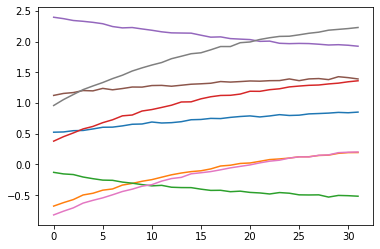

In [10]:
plt.plot(y_ijk[2, :, :].T) 

In [1]:
from doe_lhs import lhs
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
plot_range = np.linspace(0.8, 1.1, 101) 
frame_range = np.logspace(np.log10(1.), np.log10(100.), 11) 

In [3]:
design_ranges = np.array([[min(plot_range), max(plot_range)], [np.log10(min(frame_range)), np.log10(max(frame_range))]])  

In [5]:
if None: 
    print('hey')

In [6]:
np.random.seed(23)
np.random.rand(2, 11)

array([[0.51729788, 0.9469626 , 0.76545976, 0.28239584, 0.22104536,
        0.68622209, 0.1671392 , 0.39244247, 0.61805235, 0.41193009,
        0.00246488],
       [0.88403218, 0.88494754, 0.30040969, 0.58958187, 0.97842692,
        0.84509382, 0.06507544, 0.29474446, 0.28793444, 0.82246634,
        0.62618304]])

In [7]:
np.random.seed(None)
np.random.rand(2, 11)

array([[0.78139998, 0.27378346, 0.92918001, 0.90787471, 0.60424262,
        0.21613834, 0.5672272 , 0.89694213, 0.73029215, 0.30101952,
        0.37334164],
       [0.89392354, 0.80067268, 0.6232053 , 0.21649693, 0.41307301,
        0.09867334, 0.78573064, 0.75924185, 0.01349236, 0.38664569,
        0.76924607]])

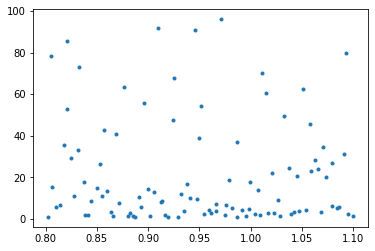

In [12]:

plt.figure() 
plt.plot(freq_samp, volt_samp, '.')

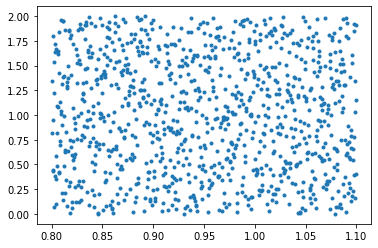

In [27]:
plt.plot(freq_samp, volt_samp, '.')

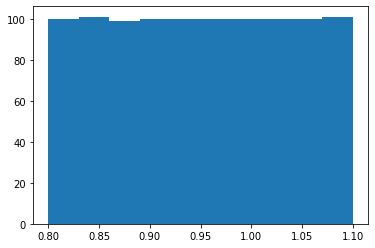

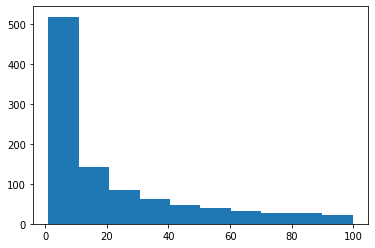

In [26]:
plt.hist(freq_samp) 
plt.figure() 
plt.hist(10 ** volt_samp); 

In [1]:
from smt.sampling_methods import LHS 

In [ ]:
LHS()